In [1]:
import torch
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics

from torch import nn
from copy import deepcopy
from tqdm import tqdm

from bayes_opt import BayesianOptimization

In [2]:
# Use the following gym version.
# pip install gym==0.25.0
# pip install pygame

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# define global variable 
MAX_EP = 1
env = gym.make('CartPole-v1')

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# Define network architecture
class Network(nn.Module):
    def __init__(self, env):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, x):
        return self.net(x)

    def act(self, state):
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = self.forward(state_t.unsqueeze(0))                           # 'q_values' outputs two values (left or right)
        max_q_index = torch.argmax(q_values, dim=1)[0]                          # find an index that corresponds to the maximum value  
        action = max_q_index.detach().item()                                    # 0 or 1
        return action                                                           # 0 or 1

In [4]:
def calculate_fitness(network, env, num_episodes=MAX_EP):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

In [5]:
def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    log_probs = []  # Store log probabilities of actions
    done = False
    while not done:
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = network(state_t.unsqueeze(0))
        action_probs = nn.functional.softmax(q_values, dim=1)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        log_probs.append(log_prob)
        state, reward, done, _ = env.step(action.item())
        total_reward += reward
    return total_reward, log_probs

In [6]:
def prepare_mutation(network, env, num_episodes=MAX_EP):
    total_rewards = 0
    all_grads = []  # List of list of gradients
    for _ in range(num_episodes):
        reward, log_probs = run_episode(network, env)
        total_rewards += reward
        loss = -reward * torch.stack(log_probs).sum()
        loss.backward()  # Calculate gradients

        grads = []  # List of gradients for this episode
        # Store gradients and zero them
        for param in network.parameters():
            grads.append(param.grad.clone())
            param.grad = None
        
        all_grads.append(grads)  # Append the list of gradients for this episode to the overall list
    
    avg_reward = total_rewards / num_episodes
    
    return avg_reward, all_grads  # Return list of list of gradients

In [7]:
def mutate_and_tournament(population, tournament_size, mutation_rate, mutation_strength):
    
    # Select individuals for the tournament
    individuals = random.sample(population, tournament_size)
    # Calculate fitness for each individual
    fitnesses = [calculate_fitness(individual, env) for individual in individuals]
    # Select the best individual
    parent = individuals[np.argmax(fitnesses)]
    
    # Create offspring by deep copying the parent
    offspring = deepcopy(parent)
    
    # Calculate fitness and gradients for the offspring
    _, all_grads = prepare_mutation(offspring, env)
    
    grads = []
    # Average gradients over episodes 
    for grad in zip(*all_grads):
        grads.append(sum(grad)/len(grad))
    
    # Apply mutation
    with torch.no_grad():
        for param, grad in zip(offspring.parameters(), grads):
            if (grad is not None) and (random.random() < mutation_rate):
                # print("mutation activated")
                delta = torch.randn_like(param)
                grad_sum = torch.sum(grad)
                if grad_sum != 0:
                    param.add_(mutation_strength * delta * grad / grad_sum)
    
    # Return the mutated offspring
    return offspring

In [8]:
# Define genetic algorithm
def main(POPULATION_SIZE, GENERATIONS, ELITISM, TOURNAMENT_SIZE, MUTATION_STRENGTH, MUTATION_RATE):
    
    FITNESS_HISTORY = list()
    FITNESS_STDERROR_HISTORY = list()
    
    # Create initial population
    population = [Network(env) for _ in range(POPULATION_SIZE)]

    for generation in range(1, GENERATIONS + 1):

        # Calculate fitness for each network
        fitnesses = [calculate_fitness(network, env) for network in tqdm(population, desc="Calculating fitnesses")]
        
        # average fitness 
        avg_fitness = np.average(fitnesses)
        max_fitness = np.max(fitnesses)
        min_fitness = np.min(fitnesses)
        FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
        
        # std error
        standard_deviation = statistics.stdev(fitnesses)
        standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
        FITNESS_STDERROR_HISTORY.append(standard_error)

        print(f"[Generation: {generation}] \n Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")
        
        # Sort population by fitness
        population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
        
        # Select the best networks to pass their genes to the next generation
        survivors = population[:ELITISM]
        
        # Create the next generation
        next_population = survivors  # Start with the survivors
        
        num_individuals_to_add = POPULATION_SIZE - len(next_population)
        # Add offspring by tournament selection and mutation
        for _ in tqdm(range(num_individuals_to_add), desc="Generating Offspring"):
            offspring = mutate_and_tournament(population, TOURNAMENT_SIZE, MUTATION_RATE, MUTATION_STRENGTH)
            next_population.append(offspring)

        # The next generation becomes the current population
        population = next_population

    return population, FITNESS_HISTORY, FITNESS_STDERROR_HISTORY

### Version Control

In [9]:
# Version 1:
# Run the genetic algorithm
population, history, history_std = main(POPULATION_SIZE=200, 
                            GENERATIONS=100, 
                            ELITISM=100, 
                            TOURNAMENT_SIZE=3, 
                            MUTATION_STRENGTH=1, 
                            MUTATION_RATE=0.01)

Calculating fitnesses:   0%|                                       | 0/200 [00:00<?, ?it/s]/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 555.48it/s]


[Generation: 1] 
 Average Fitness: 21.905 
 Best Fitness: 62.0 
 Worst Fitness: 9.0 
 Standard Error: 0.7382785048704646


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 545.07it/s]


[Generation: 2] 
 Average Fitness: 22.785 
 Best Fitness: 86.0 
 Worst Fitness: 9.0 
 Standard Error: 0.910157021628741


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 577.55it/s]


[Generation: 3] 
 Average Fitness: 21.505 
 Best Fitness: 91.0 
 Worst Fitness: 9.0 
 Standard Error: 0.8463637118067602


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 478.79it/s]


[Generation: 4] 
 Average Fitness: 22.875 
 Best Fitness: 115.0 
 Worst Fitness: 9.0 
 Standard Error: 0.986973891403191


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 504.83it/s]


[Generation: 5] 
 Average Fitness: 24.64 
 Best Fitness: 88.0 
 Worst Fitness: 9.0 
 Standard Error: 0.9893665807756894


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 482.70it/s]


[Generation: 6] 
 Average Fitness: 25.625 
 Best Fitness: 88.0 
 Worst Fitness: 8.0 
 Standard Error: 1.0588805480673336


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 498.19it/s]


[Generation: 7] 
 Average Fitness: 24.705 
 Best Fitness: 79.0 
 Worst Fitness: 9.0 
 Standard Error: 0.9949823235216809


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 458.34it/s]


[Generation: 8] 
 Average Fitness: 26.675 
 Best Fitness: 182.0 
 Worst Fitness: 9.0 
 Standard Error: 1.244241762204625


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 429.80it/s]


[Generation: 9] 
 Average Fitness: 29.21 
 Best Fitness: 131.0 
 Worst Fitness: 9.0 
 Standard Error: 1.348972994801422


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 427.90it/s]


[Generation: 10] 
 Average Fitness: 28.775 
 Best Fitness: 135.0 
 Worst Fitness: 9.0 
 Standard Error: 1.3901382292716116


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 373.74it/s]


[Generation: 11] 
 Average Fitness: 33.115 
 Best Fitness: 162.0 
 Worst Fitness: 9.0 
 Standard Error: 1.627452575168355


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 305.17it/s]


[Generation: 12] 
 Average Fitness: 41.105 
 Best Fitness: 144.0 
 Worst Fitness: 9.0 
 Standard Error: 2.058667148214028


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 248.99it/s]


[Generation: 13] 
 Average Fitness: 49.32 
 Best Fitness: 166.0 
 Worst Fitness: 10.0 
 Standard Error: 2.2850921712604455


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 219.85it/s]


[Generation: 14] 
 Average Fitness: 56.445 
 Best Fitness: 153.0 
 Worst Fitness: 10.0 
 Standard Error: 2.131678951144794


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 206.62it/s]


[Generation: 15] 
 Average Fitness: 60.39 
 Best Fitness: 157.0 
 Worst Fitness: 8.0 
 Standard Error: 2.055312885007142


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 199.84it/s]


[Generation: 16] 
 Average Fitness: 62.57 
 Best Fitness: 171.0 
 Worst Fitness: 12.0 
 Standard Error: 2.118896911273178


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 200.01it/s]


[Generation: 17] 
 Average Fitness: 62.165 
 Best Fitness: 197.0 
 Worst Fitness: 9.0 
 Standard Error: 2.3162065839856543


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 193.09it/s]


[Generation: 18] 
 Average Fitness: 64.305 
 Best Fitness: 196.0 
 Worst Fitness: 16.0 
 Standard Error: 2.2334280555677153


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 195.03it/s]


[Generation: 19] 
 Average Fitness: 60.995 
 Best Fitness: 156.0 
 Worst Fitness: 10.0 
 Standard Error: 2.0489425818010587


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 199.67it/s]


[Generation: 20] 
 Average Fitness: 62.445 
 Best Fitness: 172.0 
 Worst Fitness: 10.0 
 Standard Error: 2.3015583261440966


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 209.35it/s]


[Generation: 21] 
 Average Fitness: 58.555 
 Best Fitness: 178.0 
 Worst Fitness: 9.0 
 Standard Error: 2.240397684322941


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:00<00:00, 213.72it/s]


[Generation: 22] 
 Average Fitness: 58.13 
 Best Fitness: 160.0 
 Worst Fitness: 8.0 
 Standard Error: 2.272550976259607


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 199.07it/s]


[Generation: 23] 
 Average Fitness: 62.075 
 Best Fitness: 209.0 
 Worst Fitness: 8.0 
 Standard Error: 2.3646999607820463


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 185.10it/s]


[Generation: 24] 
 Average Fitness: 67.31 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 3.0866822864830845


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 180.93it/s]


[Generation: 25] 
 Average Fitness: 68.89 
 Best Fitness: 249.0 
 Worst Fitness: 9.0 
 Standard Error: 2.7792102381321735


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 145.86it/s]


[Generation: 26] 
 Average Fitness: 84.765 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 4.813204082803218


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:01<00:00, 116.91it/s]


[Generation: 27] 
 Average Fitness: 105.58 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 5.892019813903988


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:02<00:00, 79.84it/s]


[Generation: 28] 
 Average Fitness: 151.155 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 7.794983238818883


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:03<00:00, 55.93it/s]


[Generation: 29] 
 Average Fitness: 215.575 
 Best Fitness: 500.0 
 Worst Fitness: 30.0 
 Standard Error: 8.853743033515123


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:03<00:00, 50.88it/s]


[Generation: 30] 
 Average Fitness: 238.715 
 Best Fitness: 500.0 
 Worst Fitness: 89.0 
 Standard Error: 7.193392338925254


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 42.81it/s]


[Generation: 31] 
 Average Fitness: 278.16 
 Best Fitness: 500.0 
 Worst Fitness: 102.0 
 Standard Error: 5.490944761319248


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.75it/s]


[Generation: 32] 
 Average Fitness: 291.105 
 Best Fitness: 441.0 
 Worst Fitness: 111.0 
 Standard Error: 3.9599527781307096


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.75it/s]


[Generation: 33] 
 Average Fitness: 289.23 
 Best Fitness: 424.0 
 Worst Fitness: 115.0 
 Standard Error: 3.6495453699105007


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.38it/s]


[Generation: 34] 
 Average Fitness: 292.98 
 Best Fitness: 473.0 
 Worst Fitness: 187.0 
 Standard Error: 3.6927469314180588


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.27it/s]


[Generation: 35] 
 Average Fitness: 291.865 
 Best Fitness: 443.0 
 Worst Fitness: 187.0 
 Standard Error: 3.3159935071858166


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.98it/s]


[Generation: 36] 
 Average Fitness: 295.87 
 Best Fitness: 436.0 
 Worst Fitness: 186.0 
 Standard Error: 3.3401569938729816


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.80it/s]


[Generation: 37] 
 Average Fitness: 294.92 
 Best Fitness: 434.0 
 Worst Fitness: 191.0 
 Standard Error: 3.5021340227877973


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.51it/s]


[Generation: 38] 
 Average Fitness: 293.605 
 Best Fitness: 424.0 
 Worst Fitness: 189.0 
 Standard Error: 3.4946901394621914


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.15it/s]


[Generation: 39] 
 Average Fitness: 294.475 
 Best Fitness: 464.0 
 Worst Fitness: 191.0 
 Standard Error: 3.475325352615588


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 42.20it/s]


[Generation: 40] 
 Average Fitness: 287.11 
 Best Fitness: 410.0 
 Worst Fitness: 185.0 
 Standard Error: 3.4231607686816585


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.53it/s]


[Generation: 41] 
 Average Fitness: 299.62 
 Best Fitness: 437.0 
 Worst Fitness: 188.0 
 Standard Error: 3.504480692573882


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 42.31it/s]


[Generation: 42] 
 Average Fitness: 282.79 
 Best Fitness: 448.0 
 Worst Fitness: 165.0 
 Standard Error: 3.4421244316577337


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.48it/s]


[Generation: 43] 
 Average Fitness: 291.305 
 Best Fitness: 448.0 
 Worst Fitness: 195.0 
 Standard Error: 3.4732082796412946


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.03it/s]


[Generation: 44] 
 Average Fitness: 293.04 
 Best Fitness: 474.0 
 Worst Fitness: 187.0 
 Standard Error: 3.6615401652732893


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 42.08it/s]


[Generation: 45] 
 Average Fitness: 287.75 
 Best Fitness: 408.0 
 Worst Fitness: 193.0 
 Standard Error: 3.2521639490897125


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.22it/s]


[Generation: 46] 
 Average Fitness: 293.395 
 Best Fitness: 417.0 
 Worst Fitness: 191.0 
 Standard Error: 3.034242576834518


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.47it/s]


[Generation: 47] 
 Average Fitness: 288.93 
 Best Fitness: 408.0 
 Worst Fitness: 184.0 
 Standard Error: 3.5096529485257477


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.05it/s]


[Generation: 48] 
 Average Fitness: 295.875 
 Best Fitness: 445.0 
 Worst Fitness: 193.0 
 Standard Error: 3.4119722519740994


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.52it/s]


[Generation: 49] 
 Average Fitness: 290.19 
 Best Fitness: 438.0 
 Worst Fitness: 190.0 
 Standard Error: 3.203706945236217


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.26it/s]


[Generation: 50] 
 Average Fitness: 293.8 
 Best Fitness: 436.0 
 Worst Fitness: 190.0 
 Standard Error: 3.3166399416446404


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.35it/s]


[Generation: 51] 
 Average Fitness: 298.96 
 Best Fitness: 423.0 
 Worst Fitness: 191.0 
 Standard Error: 3.7680609624958863


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.29it/s]


[Generation: 52] 
 Average Fitness: 298.83 
 Best Fitness: 439.0 
 Worst Fitness: 186.0 
 Standard Error: 3.262379669126148


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.55it/s]


[Generation: 53] 
 Average Fitness: 292.04 
 Best Fitness: 427.0 
 Worst Fitness: 158.0 
 Standard Error: 3.5889055735809494


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.32it/s]


[Generation: 54] 
 Average Fitness: 292.565 
 Best Fitness: 444.0 
 Worst Fitness: 184.0 
 Standard Error: 3.5618058875947356


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.66it/s]


[Generation: 55] 
 Average Fitness: 296.645 
 Best Fitness: 439.0 
 Worst Fitness: 190.0 
 Standard Error: 3.5884088766933537


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.47it/s]


[Generation: 56] 
 Average Fitness: 296.6 
 Best Fitness: 500.0 
 Worst Fitness: 189.0 
 Standard Error: 3.6205096950928475


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.46it/s]


[Generation: 57] 
 Average Fitness: 296.495 
 Best Fitness: 435.0 
 Worst Fitness: 188.0 
 Standard Error: 3.7631444505597833


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.17it/s]


[Generation: 58] 
 Average Fitness: 299.49 
 Best Fitness: 455.0 
 Worst Fitness: 187.0 
 Standard Error: 3.563522550065331


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.56it/s]


[Generation: 59] 
 Average Fitness: 289.565 
 Best Fitness: 467.0 
 Worst Fitness: 188.0 
 Standard Error: 3.7343884587444864


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.19it/s]


[Generation: 60] 
 Average Fitness: 295.545 
 Best Fitness: 459.0 
 Worst Fitness: 190.0 
 Standard Error: 3.6450820278767044


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.77it/s]


[Generation: 61] 
 Average Fitness: 294.845 
 Best Fitness: 419.0 
 Worst Fitness: 184.0 
 Standard Error: 3.424307856557645


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.85it/s]


[Generation: 62] 
 Average Fitness: 294.585 
 Best Fitness: 435.0 
 Worst Fitness: 182.0 
 Standard Error: 3.6024648004097077


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.21it/s]


[Generation: 63] 
 Average Fitness: 301.965 
 Best Fitness: 473.0 
 Worst Fitness: 186.0 
 Standard Error: 3.914984597285783


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.45it/s]


[Generation: 64] 
 Average Fitness: 290.67 
 Best Fitness: 422.0 
 Worst Fitness: 189.0 
 Standard Error: 3.4229062117845657


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.18it/s]


[Generation: 65] 
 Average Fitness: 294.11 
 Best Fitness: 424.0 
 Worst Fitness: 189.0 
 Standard Error: 3.3908744666002018


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.49it/s]


[Generation: 66] 
 Average Fitness: 298.865 
 Best Fitness: 438.0 
 Worst Fitness: 195.0 
 Standard Error: 3.272327076789152


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.16it/s]


[Generation: 67] 
 Average Fitness: 294.675 
 Best Fitness: 450.0 
 Worst Fitness: 187.0 
 Standard Error: 3.421069343386846


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.42it/s]


[Generation: 68] 
 Average Fitness: 290.805 
 Best Fitness: 476.0 
 Worst Fitness: 186.0 
 Standard Error: 3.4926822100071604


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.18it/s]


[Generation: 69] 
 Average Fitness: 294.95 
 Best Fitness: 418.0 
 Worst Fitness: 187.0 
 Standard Error: 3.4876577070301833


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.94it/s]


[Generation: 70] 
 Average Fitness: 295.755 
 Best Fitness: 429.0 
 Worst Fitness: 189.0 
 Standard Error: 3.313536251112576


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.32it/s]


[Generation: 71] 
 Average Fitness: 298.855 
 Best Fitness: 464.0 
 Worst Fitness: 185.0 
 Standard Error: 3.354981277423064


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.78it/s]


[Generation: 72] 
 Average Fitness: 295.905 
 Best Fitness: 430.0 
 Worst Fitness: 185.0 
 Standard Error: 3.49299081003586


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.27it/s]


[Generation: 73] 
 Average Fitness: 294.425 
 Best Fitness: 432.0 
 Worst Fitness: 198.0 
 Standard Error: 3.436732097874784


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.35it/s]


[Generation: 74] 
 Average Fitness: 292.315 
 Best Fitness: 500.0 
 Worst Fitness: 183.0 
 Standard Error: 3.584868937842433


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.34it/s]


[Generation: 75] 
 Average Fitness: 290.985 
 Best Fitness: 423.0 
 Worst Fitness: 185.0 
 Standard Error: 3.244604934488099


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.55it/s]


[Generation: 76] 
 Average Fitness: 288.365 
 Best Fitness: 416.0 
 Worst Fitness: 182.0 
 Standard Error: 3.65301677147304


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.01it/s]


[Generation: 77] 
 Average Fitness: 291.39 
 Best Fitness: 444.0 
 Worst Fitness: 187.0 
 Standard Error: 3.7184639801750525


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.76it/s]


[Generation: 78] 
 Average Fitness: 299.085 
 Best Fitness: 432.0 
 Worst Fitness: 190.0 
 Standard Error: 3.7573363914871885


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.21it/s]


[Generation: 79] 
 Average Fitness: 298.05 
 Best Fitness: 437.0 
 Worst Fitness: 193.0 
 Standard Error: 3.5356458331239047


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.27it/s]


[Generation: 80] 
 Average Fitness: 297.475 
 Best Fitness: 471.0 
 Worst Fitness: 184.0 
 Standard Error: 3.7863875300394425


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.12it/s]


[Generation: 81] 
 Average Fitness: 292.21 
 Best Fitness: 417.0 
 Worst Fitness: 184.0 
 Standard Error: 3.4695632065464816


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.96it/s]


[Generation: 82] 
 Average Fitness: 299.38 
 Best Fitness: 430.0 
 Worst Fitness: 193.0 
 Standard Error: 3.1016899267995903


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.47it/s]


[Generation: 83] 
 Average Fitness: 296.565 
 Best Fitness: 418.0 
 Worst Fitness: 184.0 
 Standard Error: 3.331218087235301


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.07it/s]


[Generation: 84] 
 Average Fitness: 293.16 
 Best Fitness: 431.0 
 Worst Fitness: 189.0 
 Standard Error: 3.7702447836504214


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.22it/s]


[Generation: 85] 
 Average Fitness: 297.74 
 Best Fitness: 491.0 
 Worst Fitness: 192.0 
 Standard Error: 3.5721440431940357


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.30it/s]


[Generation: 86] 
 Average Fitness: 291.81 
 Best Fitness: 456.0 
 Worst Fitness: 193.0 
 Standard Error: 3.371782031856709


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.74it/s]


[Generation: 87] 
 Average Fitness: 290.5 
 Best Fitness: 450.0 
 Worst Fitness: 188.0 
 Standard Error: 3.5893617243097276


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 38.94it/s]


[Generation: 88] 
 Average Fitness: 301.605 
 Best Fitness: 450.0 
 Worst Fitness: 191.0 
 Standard Error: 3.6878238977074966


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.32it/s]


[Generation: 89] 
 Average Fitness: 293.84 
 Best Fitness: 456.0 
 Worst Fitness: 193.0 
 Standard Error: 3.6542632911443342


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.68it/s]


[Generation: 90] 
 Average Fitness: 298.13 
 Best Fitness: 420.0 
 Worst Fitness: 189.0 
 Standard Error: 3.269866301263815


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.85it/s]


[Generation: 91] 
 Average Fitness: 295.46 
 Best Fitness: 460.0 
 Worst Fitness: 191.0 
 Standard Error: 3.7790206383300715


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.29it/s]


[Generation: 92] 
 Average Fitness: 295.575 
 Best Fitness: 441.0 
 Worst Fitness: 185.0 
 Standard Error: 3.775346085503504


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 38.61it/s]


[Generation: 93] 
 Average Fitness: 295.445 
 Best Fitness: 437.0 
 Worst Fitness: 190.0 
 Standard Error: 3.532154505717623


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.60it/s]


[Generation: 94] 
 Average Fitness: 296.15 
 Best Fitness: 410.0 
 Worst Fitness: 199.0 
 Standard Error: 3.301010580757256


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.33it/s]


[Generation: 95] 
 Average Fitness: 292.295 
 Best Fitness: 451.0 
 Worst Fitness: 186.0 
 Standard Error: 3.5729637874082423


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 41.14it/s]


[Generation: 96] 
 Average Fitness: 288.955 
 Best Fitness: 432.0 
 Worst Fitness: 185.0 
 Standard Error: 3.2781927358020493


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.64it/s]


[Generation: 97] 
 Average Fitness: 293.05 
 Best Fitness: 457.0 
 Worst Fitness: 187.0 
 Standard Error: 3.5899899217394684


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:05<00:00, 39.38it/s]


[Generation: 98] 
 Average Fitness: 300.27 
 Best Fitness: 482.0 
 Worst Fitness: 185.0 
 Standard Error: 3.607973512142461


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.67it/s]


[Generation: 99] 
 Average Fitness: 290.245 
 Best Fitness: 472.0 
 Worst Fitness: 193.0 
 Standard Error: 3.4034087073323604


Calculating fitnesses: 100%|█████████████████████████████| 200/200 [00:04<00:00, 40.46it/s]


[Generation: 100] 
 Average Fitness: 295.25 
 Best Fitness: 428.0 
 Worst Fitness: 188.0 
 Standard Error: 3.532012608319318


Generating Offspring: 100%|██████████████████████████████| 100/100 [00:11<00:00,  8.99it/s]


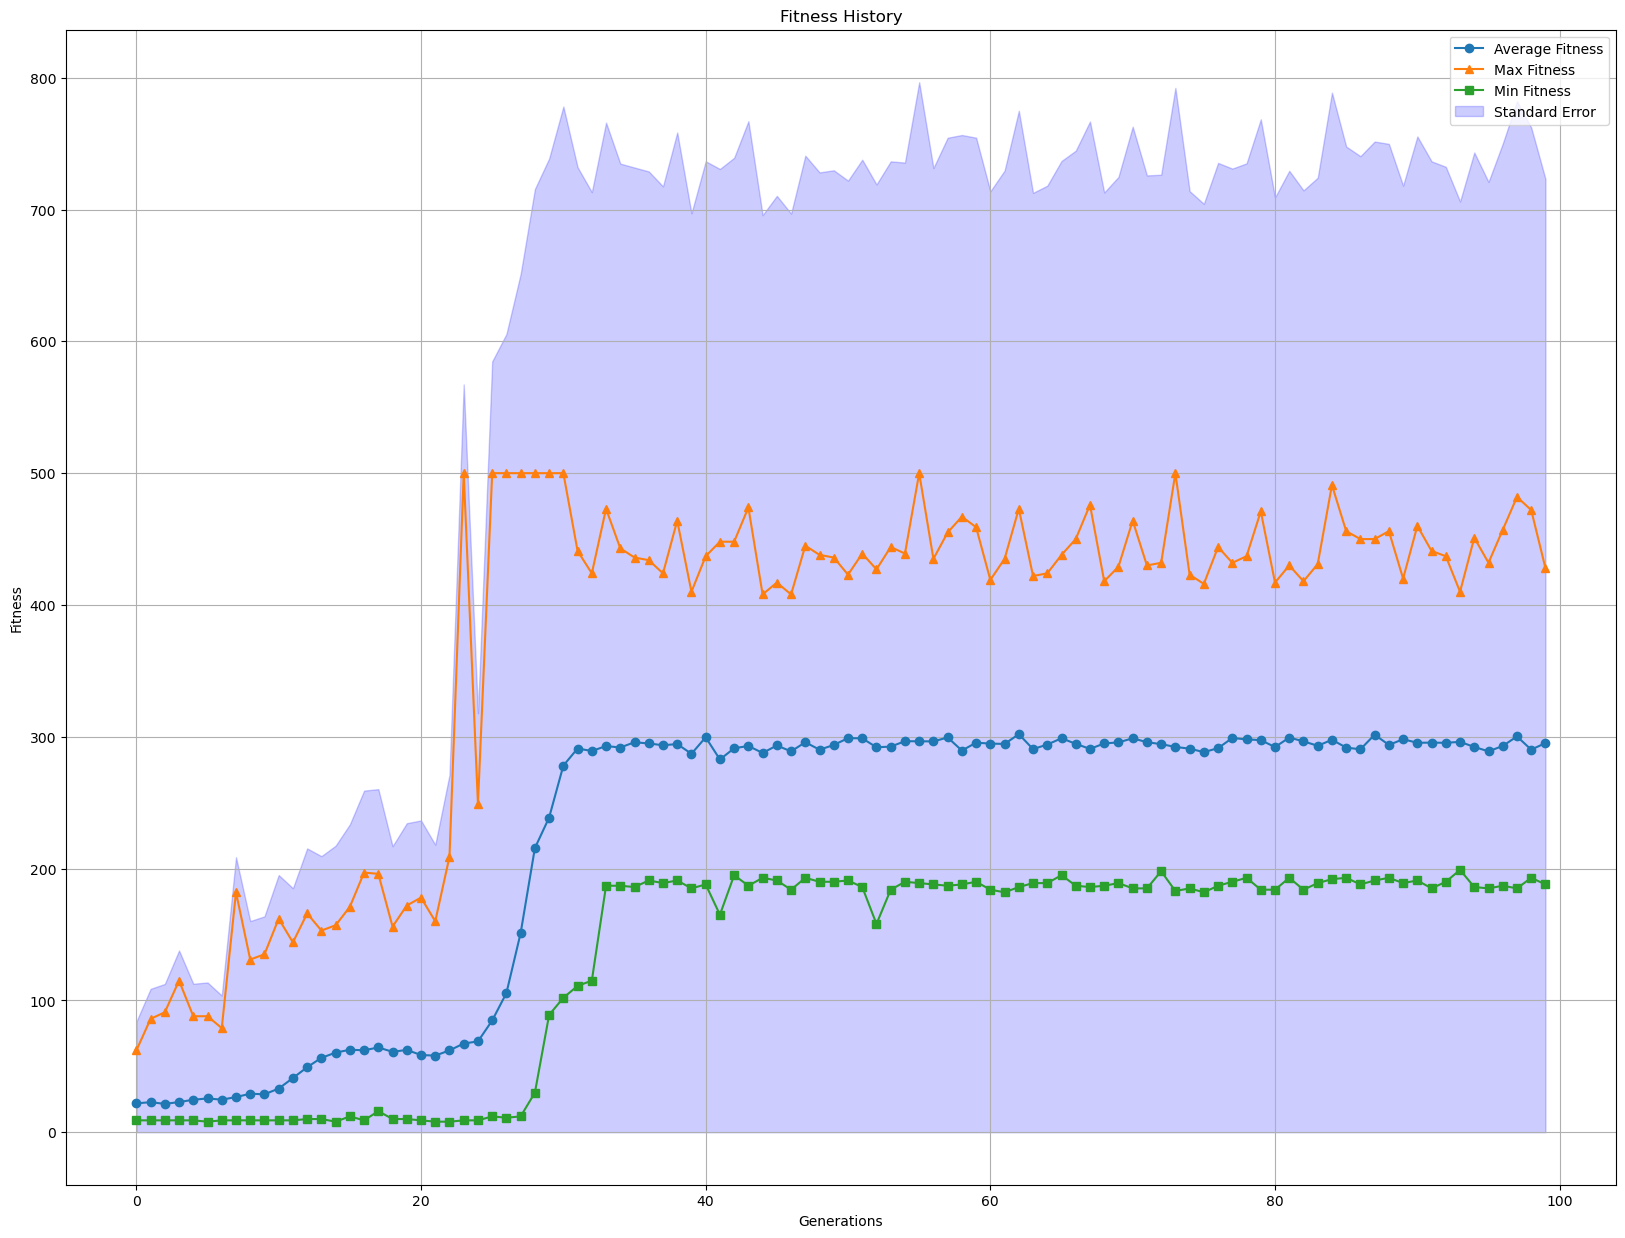

In [13]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(100), np.array(history)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(100), np.array(history)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(100), np.array(history)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(100), 0, np.array(history)[:,0] + np.array(history)[:,1],
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()